## Exercise 3 - Validation
#### Ove Haugvaldstad

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
from plotWorldview import plot
%matplotlib inline

### 1.
#### Read MODIS 

In [2]:
# Read in csv and convert index to datetime
df_Modis = pd.read_csv('MODIS_Aqua_coll6_AOD_at_Cart_Site_05deg_box.csv', header=None,
                        names=['Year','Month', 'Day', 'Lat','Lon', 
                               'AOD_440nm', 'AOD_550nm','AOD_660nm'])
df_Modis.index= pd.to_datetime(df_Modis[['Year', 'Month', 'Day']], yearfirst=True)
df_Modis = df_Modis.drop(['Year','Month', 'Day'], axis=1)

df_Modis.head()

,Lat,Lon,AOD_440nm,AOD_550nm,AOD_660nm
2009-04-03,36.728653,-96.997261,0.057,0.051,0.046
2009-04-03,36.818497,-97.017105,0.019,0.014,0.010
2009-04-03,36.906712,-97.034599,0.024,0.018,0.013
2009-04-03,36.996593,-97.054138,NaN,NaN,NaN
2009-04-03,37.084789,-97.071823,0.008,0.006,0.004


#### Read AERONET

In [3]:
#Read in csv and convert index to datetime 
cols = ['Year','Month', 'Day', 'Hour', 'min' , 'AOD_1640nm', 'AOD_1020nm'
       ,'AOD_870nm', 'AOD_675nm', 'AOD_500nm', 'AOD_440nm', 'Angstr_coeff', 'Angstr_coeff_870-500nm'
        ,'Water vapor', 'sza']
df_AeroNet = pd.read_csv('AERONET_AODs_lev20_Cart_Site_all.csv', header=None, names=cols)


df_time = df_AeroNet.copy()[['Year', 'Month', 'Day', 'Hour', 'min']]
df_time['Hour'] = df_time['Hour'] + df_time['min']/60
df_time = df_time.drop('min', axis=1)
#Subtract 5 hours to convert to local time
dateIndex = (pd.to_datetime(df_time, errors='ignore', format='%Y%m%d%H').dt.round('min'))



df_AeroNet.index = dateIndex
df_AeroNet = df_AeroNet.drop(['Year','Month', 'Day', 'Hour', 'min' ], axis=1)
df_AeroNet.head()

,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,Angstr_coeff,Angstr_coeff_870-500nm,Water vapor,sza
2002-01-02 14:57:00,NaN,0.089399,0.101951,0.138971,0.191453,0.220339,1.126758,1.139243,0.301580,78.290231
2002-01-02 15:06:00,NaN,0.078803,0.090424,0.127009,0.180836,0.208729,1.227423,1.253102,0.304640,76.992724
2002-01-02 15:17:00,NaN,0.089938,0.101863,0.142102,0.200244,0.235192,1.219486,1.221904,0.303690,75.359144
2002-01-02 15:24:00,NaN,0.111820,0.129356,0.175880,0.237530,0.270216,1.075806,1.097860,0.301791,74.294612
2002-01-02 15:29:00,NaN,0.111969,0.128726,0.175240,0.237836,0.269820,1.083041,1.109198,0.306030,73.719903


#### a)

Text(0, 0.5, 'AOD')

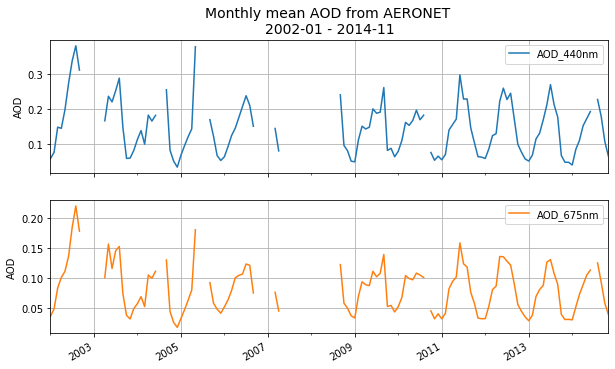

In [4]:
monthlyMeanAOD = df_AeroNet[['AOD_440nm', 'AOD_675nm']].resample('M').mean()
ax = monthlyMeanAOD.plot(subplots=True, grid=True, figsize=(10,6))
ax[0].set_title('Monthly mean AOD from AERONET \n' + '{} - {}'.format(
                    monthlyMeanAOD.index[0].asm8.astype('<M8[M]'), 
                    monthlyMeanAOD.index[-1].asm8.astype('<M8[M]')),fontsize=14)
ax[0].set_ylabel('AOD')
ax[1].set_ylabel('AOD')

a) The timeseries of monthly mean AOD from the AERONET shows a distict seasonallity, where the lowest AOD is observed during the winter , january - feburary. Which might be because there are more VOC aerosols produced by the surrounding vegetation in combination with increased human activity aswell. 

In [5]:
validation13pm = df_AeroNet[['AOD_440nm', 'AOD_675nm']].between_time('18:00', '19:00').resample('D').mean()
validation13pm['Modis_AOD_440nm'] = df_Modis['AOD_440nm'].resample('D').mean()
validation13pm['Modis_AOD_660nm'] = df_Modis['AOD_660nm'].resample('D').mean()
validation13pm = validation13pm.dropna()

correlation = validation13pm.corr()

### AOD 440 nm AERONET compared to AOD 440nm MODIS
#### b)

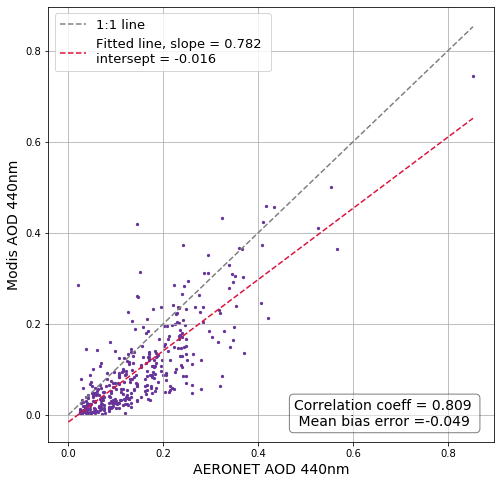

In [11]:
#OLS fit
model = smf.ols(formula='Modis_AOD_440nm ~ AOD_440nm', data=validation13pm)
fit = model.fit()
alpha = fit.params[0]
beta = fit.params[1]

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

meanbias = (validation13pm['Modis_AOD_440nm'] - validation13pm['AOD_440nm']).mean()

x = np.linspace(0,max(validation13pm['AOD_440nm']),100)
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(validation13pm['AOD_440nm'], 
            validation13pm['Modis_AOD_440nm'], s = 5, color = 'rebeccapurple', label=None)

ax.set_ylabel('Modis AOD 440nm', fontsize = 14)
ax.plot(x,x, color = 'grey', linestyle = '--', label='1:1 line')
ax.plot(x, alpha + beta*x, color = 'crimson', linestyle = '--', 
         label='Fitted line, slope = {:.3f} \n'.format(beta) + 'intersept = {:.3f}'.format(alpha))
ax.set_xlabel('AERONET AOD 440nm', fontsize = 14)
plt.text(0.55, 0.1, 'Correlation coeff = {:.3f} \n Mean bias error ={:.3f}'.format(correlation.iloc[0,2], meanbias),
         transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.grid()
plt.legend(fontsize=13);

### AOD 675nm AERONET compared to MODIS AOD 670nm 

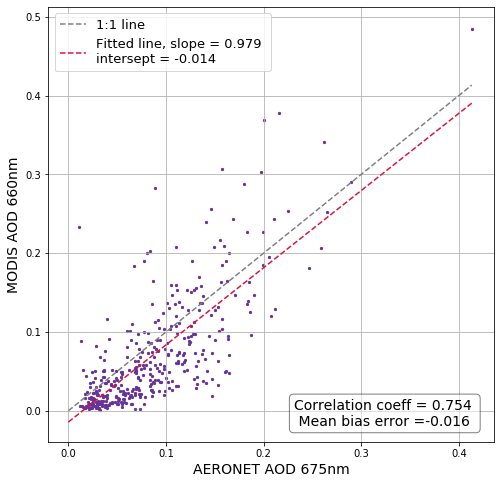

In [9]:
model = smf.ols(formula='Modis_AOD_660nm ~ AOD_675nm', data=validation13pm)
fit = model.fit()
alpha = fit.params[0]
beta = fit.params[1]
meanbias = (validation13pm['Modis_AOD_660nm'] - validation13pm['AOD_675nm']).mean()

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

x = np.linspace(0,max(validation13pm['AOD_675nm']),100)
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(validation13pm['AOD_675nm'], 
            validation13pm['Modis_AOD_660nm'], s = 5, color = 'rebeccapurple', label=None)

ax.set_ylabel('MODIS AOD 660nm', fontsize = 14)
ax.plot(x,x, color = 'grey', linestyle = '--', label='1:1 line')
ax.plot(x, alpha + beta*x, color = 'crimson', linestyle = '--', 
         label='Fitted line, slope = {:.3f} \n'.format(beta) + 'intersept = {:.3f}'.format(alpha))
ax.set_xlabel('AERONET AOD 675nm', fontsize = 14)
plt.text(0.55, 0.1, 'Correlation coeff = {:.3f} \n Mean bias error ={:.3f}'.format(correlation.iloc[1,-1], meanbias),
         transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.grid()
plt.legend(fontsize=13);

Looking at the scatter plots, the AOD from MODIS seems to generally underestimate the AOD both 660nm and 440nm. The underestimation is largest during clear conditions when the obeserved AOD is small. That MODIS fails to accurately estimate the AOD during for unpolluted condition at the AERONET might be that air so clean that AOD approaches the detection limit of the sensor. Still a correlation of 0.754 and 0.809 for AOD 660nm and AOD 440nm shows that the overall performance of MODIS is quite good.      

### 2. Case study - Air pollution episode in Nothern India 

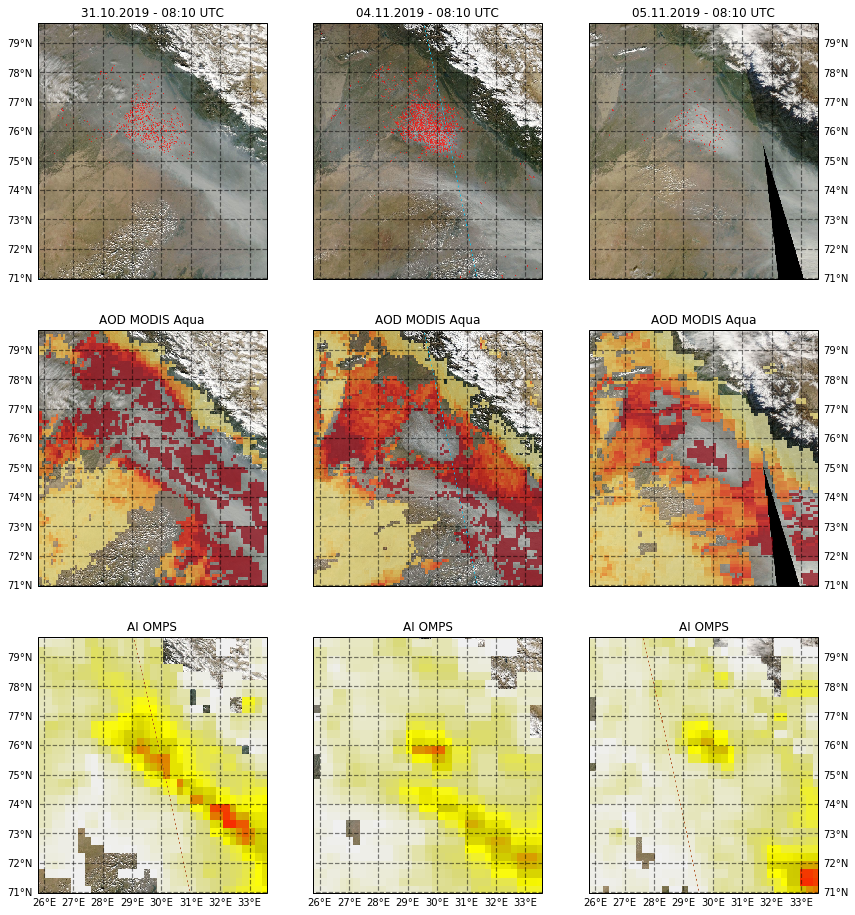

In [8]:
plot()


#### AOD (approximate)
* AOD range near New Delhi 31.10.2019: **2.420 - 2.850** 
* AOD range near New Delhi 04.11.2019: **0.695 - 0.700** 
* AOD range near New Delhi 05.11.2019: **0.475 - 0.500**

#### AI (approximate)
* AI range near New Delhi 31.10.2019: **2.850 - 2.875**
* AI range near New Delhi 04.11.2019: **1.200 - 1.225**
* AI range near New Delhi 05.11.2019: **0.475 - 0.510**


It is difficult to tell the exact cause of the fires from the true color images, but I would guess that it caused by wildfires. 

Whats interesting to see when comparing the aerosol index and the aerosol optical depth, is that the smoke from the fires is so bright that AOD retrival indentifes the smoke plume as a cloud. While from the AI retrival it obvious that there is a lot of aerosols present